In [2]:
# Autoencoder neural network for dimensionality reduction of rehabilitation movement data
import numpy as np
np.random.seed(1337)  # for reproducibility

# It is strongly recommended to use a GPU for this step, otherwise the training may take a very long time
# If you do use a CPU, replace CuDDLSTM with LSTM below, and also in cell 5
from keras.models import Model
from keras.layers import Input, LSTM
# from keras.utils import utils
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

Using TensorFlow backend.


In [ ]:
now = datetime.now

batch_size = 10
n_timesteps = 240 # length of data sequences
n_dim = 117 # dimension of data sequences


In [3]:
# Navigate to the local folder in your Google Drive
# cd "drive/My Drive/Colab Notebooks/Rehabilitation_Evaluation/A_DL_Framework"

/content/drive/My Drive/Colab Notebooks/Rehabilitation_Evaluation/A_DL_Framework


In [1]:
# Import the data
from movements.ViconDataLoader import loadData

n_movements = 1
correct_seq_num = 90
incorrect_seq_num = 90
n_dim_correct = 117
n_dim_incorrect =  117
n_frames = 240

X_correct, X_incorrect = loadData(correct_seq_num, incorrect_seq_num, n_movements, n_dim_correct, n_dim_incorrect, n_frames)

print(X_correct.shape, 'correct sequences')
print(X_incorrect.shape, 'incorrect sequences')

# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(X_correct[0])
plt.ylim([-1,1])
plt.subplot(1,2,2)
plt.plot(X_incorrect[0])
plt.ylim([-1,1])
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'ViconDataLoader'

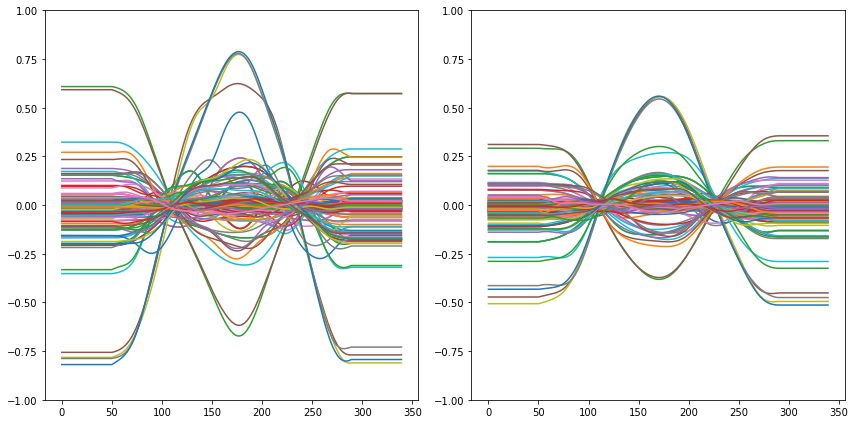

In [5]:
# Add 50 time frames at the beginning and end of sequences
# The autoencoder has difficulties with the beginning and ending frames
data_correct = np.zeros((X_correct.shape[0],n_timesteps+100,n_dim))
for i in range(X_correct.shape[0]):
    data_correct[i,:,:] = np.concatenate((np.concatenate((np.tile(X_correct[i,0,:],[50, 1]), X_correct[i,:,:])), np.tile(X_correct[i,-1,:],[50, 1])))

data_incorrect = np.zeros((X_incorrect.shape[0],n_timesteps+100,n_dim))
for i in range(X_incorrect.shape[0]):
    data_incorrect[i,:,:] = np.concatenate((np.concatenate((np.tile(X_incorrect[i,0,:],[50, 1]), X_incorrect[i,:,:])), np.tile(X_incorrect[i,-1,:],[50, 1])))
    
# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(data_correct[0])
plt.ylim([-1,1])
plt.subplot(1,2,2)
plt.plot(data_incorrect[0])
plt.ylim([-1,1])
plt.tight_layout()
plt.show()

In [6]:
# Encoder layers
input_seq = Input(shape=(n_timesteps+100,n_dim))
encoded1 = LSTM(30,return_sequences = True)(input_seq)
encoded2 = LSTM(10,return_sequences = True)(encoded1)
# Encoded representation of the input, 340x4 vector
encoded = LSTM(4,return_sequences = True)(encoded2)
# Decoder layers
decoded1 = LSTM(10,return_sequences = True)(encoded)
decoded2 = LSTM(30,return_sequences = True)(decoded1)
decoded = LSTM(n_dim, return_sequences = True)(decoded2)

# The model maps an input to its reconstruction
autoencoder = Model(inputs=input_seq, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 340, 117)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 340, 30)           17880     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 340, 10)           1680      
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 340, 4)            256       
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 340, 10)           640       
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 340, 30)           5040      
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 340, 117)          

In [ ]:
# Shuffle the sequences to create a training and validation sets
import random
trainidx = random.sample(range(0,data_correct.shape[0]),63)
valididx = np.setdiff1d(np.arange(0,90,1),trainidx)
train_data = data_correct[trainidx,:,:]
valid_data = data_correct[valididx,:,:]

In [8]:
# Train an autoencoder on the correct data sequences

# Measure the training time 
t = now()

# Request to stop before reaching the number of epochs if the validation loss does not decrease for 1000 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience = 1000)

history = autoencoder.fit(train_data, train_data, epochs = 10000, batch_size = batch_size, shuffle=True,
                validation_data=(valid_data, valid_data), verbose = 0, callbacks = [early_stopping])

print('Training time: %s' % (now() - t))









Training time: 0:44:05.245553


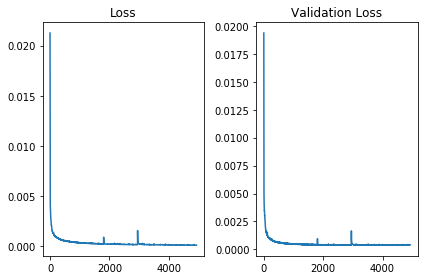

0.0001340331920858709
0.0004061685931109996


In [9]:
# Plot the training and validation results
plt.figure(1)
plt.subplot(121)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.tight_layout()
plt.show()

# Print the resulting training and validation loss values
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

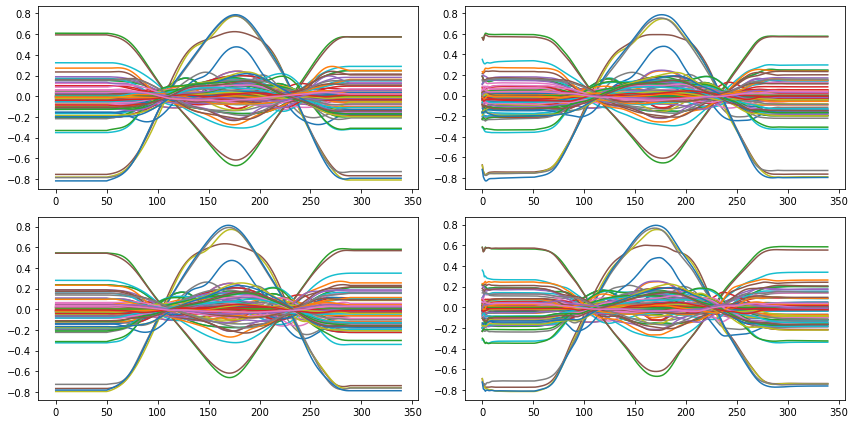

In [10]:
# Encode and decode sequences to check the model performance
decoded_seqs = autoencoder.predict(data_correct)
# Plot the results
n = 2  # how many sequences we will display
plt.figure(figsize = (12,6))
for i in range(n):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(data_correct[i])
    
    # display reconstruction
    plt.subplot(n, 2, 2*i+2)
    plt.plot(decoded_seqs[i])
plt.tight_layout()
plt.show()

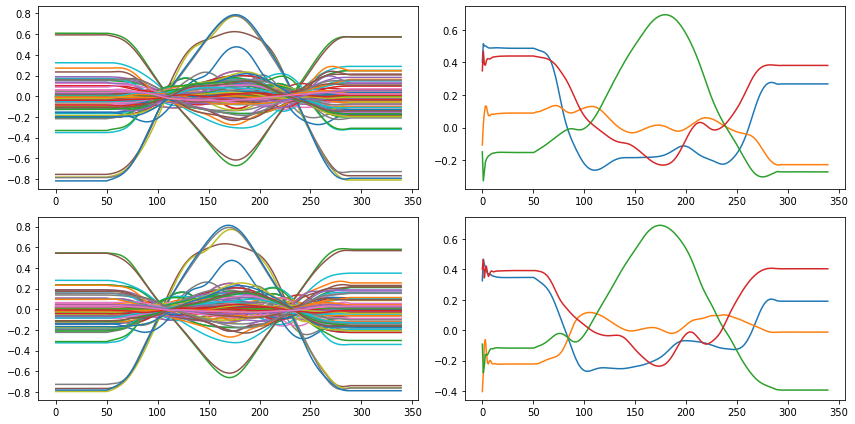

In [11]:
# Create an encoder model, that maps an input to its encoded representation
encoder = Model(inputs=input_seq, outputs=encoded)

# Test the encoder model
encoded_seqs = encoder.predict(data_correct)

# Plot the results
n = 2  # how many sequences we will display
plt.figure(figsize = (12,6))
for i in range(n):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(data_correct[i])
    
    # display reconstruction
    plt.subplot(n, 2, 2*i+2)
    plt.plot(encoded_seqs[i])
plt.tight_layout()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the s

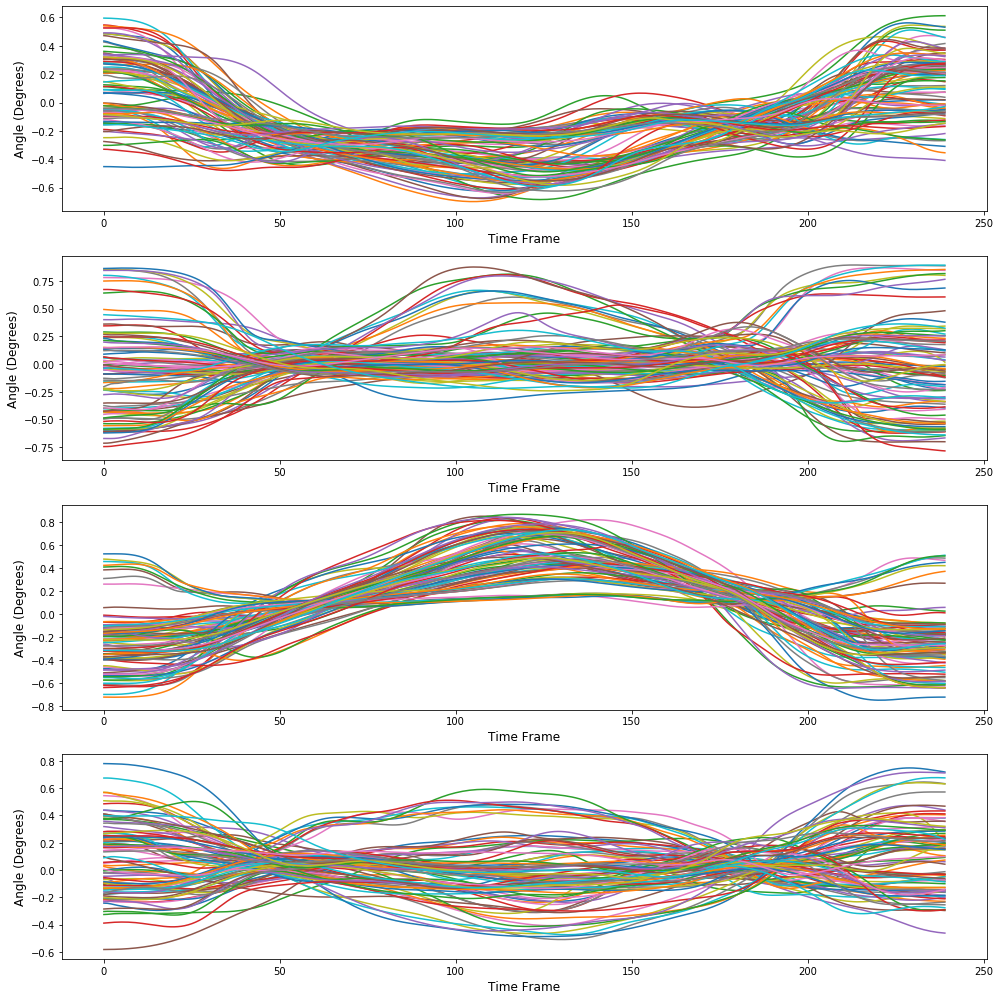

In [12]:
# Plot all encoded sequences without the first and last 50 time frames
plt.figure(figsize = (14,14))
for i in range(data_correct.shape[0]):
    plt.subplot(4,1,1)
    plt.plot(encoded_seqs[i,50:-50,0])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,2)
    plt.plot(encoded_seqs[i,50:-50,1])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,3)
    plt.plot(encoded_seqs[i,50:-50,2])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,4)
    plt.plot(encoded_seqs[i,50:-50,3])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# autoencoder.save_weights('M01_Autoencoder.h5')

In [14]:
# Remove the added first and last 50 frames 
encoded_seqs = encoded_seqs[:,50:-50,:]

print(encoded_seqs.shape, 'encoded sequences shape')
# Reshape the encoded sequences, because savetxt saves two dimensional data
seqs = encoded_seqs.reshape(encoded_seqs.shape[0],encoded_seqs.shape[1]*encoded_seqs.shape[2])
print(seqs.shape, 'encoded sequences shape for saving')
# Save the data in the file 'Autoencoder_Output_Correct.csv'
np.savetxt('Autoencoder_Output_Correct.csv', seqs, fmt='%.5f',delimiter=',')

(90, 240, 4) encoded sequences shape
(90, 960) encoded sequences shape for saving


In [ ]:
# Reduce the dimensionality of the incorrect sequences
encoded_seqs_incorrect = encoder.predict(data_incorrect)

In [16]:
# Remove the added first and last 50 frames 
encoded_seqs_incorrect = encoded_seqs_incorrect[:,50:-50,:]

print(encoded_seqs_incorrect.shape, 'encoded incorrect sequences shape')
# Reshape the encoded sequences, because savetxt saves only tow dimensional data
seqs_incorrect = encoded_seqs_incorrect.reshape(encoded_seqs_incorrect.shape[0],encoded_seqs_incorrect.shape[1]*encoded_seqs_incorrect.shape[2])
print(seqs_incorrect.shape, 'encoded incorrect sequences shape for saving')
# Save the incorrect data in the file 'Autoencoder_Output_Incorrect.csv'
np.savetxt('Autoencoder_Output_Incorrect.csv', seqs_incorrect, fmt='%.5f',delimiter=',')

(90, 240, 4) encoded incorrect sequences shape
(90, 960) encoded incorrect sequences shape for saving
